Práctica 2
# 1. Introducción al problema a solucionar
La práctica tiene como objetivo principal demostrar la comprensión y aplicación de los conceptos relacionados con el diseño y uso de redes neuronales, los cuales han sido explicados durante las sesiones presenciales de la asignatura. Para ello, se solicita la implementación y evaluación de al menos dos modelos basados en redes neuronales utilizando la biblioteca PyTorch.

El modelo debe resolver un problema específico relacionado con el conjunto de datos proporcionado: The Oxford-IIIT Pet Dataset. 
Para esta práctica se ha hecho uso de Google Colab debido a que algunos de los modelos requieren una tarjeta gráfica mejor.

Primero de todo importamos las librerías necesarias para la práctica.

## Importamos las librerias

In [50]:
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

Tenemos la carpeta de imágenes en el mismo directorio y una carpeta *annotations* con un archivo .txt donde se describe cada columna:
* Image 
* CLASS-ID: Class ids
* SPECIES: 1:Cat 2:Dog
* BREED ID: 1-25:Cat 1:12:Dog

In [51]:
images = 'images/'
annotations = 'annotations/list.txt'

# Leer el archivo y crear el DataFrame
with open(annotations, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

cols = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=cols)

# Concatenar la ruta de la imagen
df["Image"] = images + df["Image"] + '.jpg'

# Convertir columnas a tipo de datos adecuado
numeric_columns = ["CLASS-ID", "SPECIES", "BREED ID"]
df[numeric_columns] = df[numeric_columns].astype('int64')

df[numeric_columns] -= 1

print(df)


                                Image  CLASS-ID  SPECIES  BREED ID
0           images/Abyssinian_100.jpg         0        0         0
1           images/Abyssinian_101.jpg         0        0         0
2           images/Abyssinian_102.jpg         0        0         0
3           images/Abyssinian_103.jpg         0        0         0
4           images/Abyssinian_104.jpg         0        0         0
...                               ...       ...      ...       ...
7344  images/yorkshire_terrier_96.jpg        36        1        24
7345  images/yorkshire_terrier_97.jpg        36        1        24
7346  images/yorkshire_terrier_98.jpg        36        1        24
7347  images/yorkshire_terrier_99.jpg        36        1        24
7348   images/yorkshire_terrier_9.jpg        36        1        24

[7349 rows x 4 columns]


Mostramos las diferentes clases y como sabemos que nuestro conjunto de datos son imágenes de perros y gatos, vamos a mostrar la distribución de cada especie.

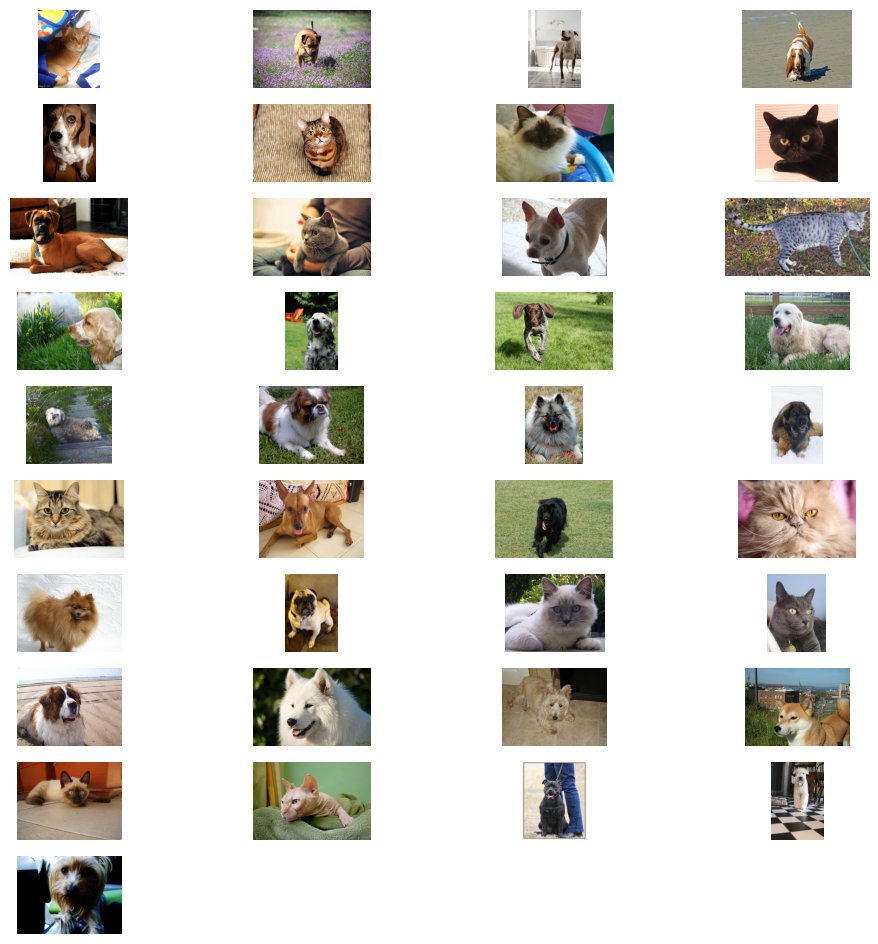

In [52]:
num_classes = len(df["CLASS-ID"].unique())
rows = num_classes // 4 + 1
cols = 4

plt.figure(figsize=(12, 12))

for i, class_id in enumerate(df["CLASS-ID"].unique()):
    class_sample = df[df["CLASS-ID"] == class_id].iloc[0]
    img = imread(class_sample["Image"])

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
plt.show()

C:\Users\alero\AppData\Local\Temp\ipykernel_19268\1956270645.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=species_counts.index, y=species_counts.values, palette="viridis")


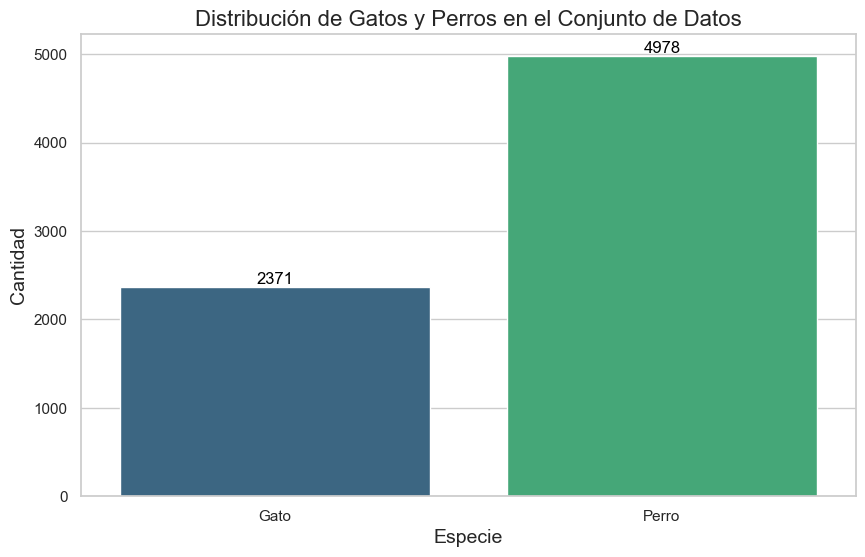

In [53]:
df["SPECIES"] = df["SPECIES"].map({0: "Gato", 1: "Perro"})


species_counts = df["SPECIES"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=species_counts.index, y=species_counts.values, palette="viridis")

plt.title('Distribución de Gatos y Perros en el Conjunto de Datos', fontsize=16)
plt.xlabel('Especie', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(rotation=0)

for i, count in enumerate(species_counts.values):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12, color='black')

plt.show()

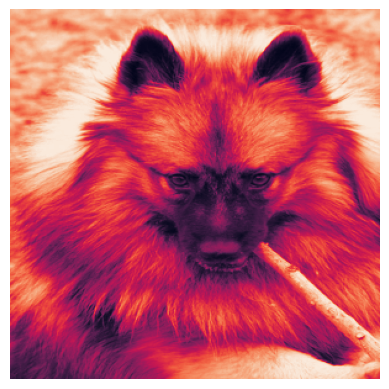

AttributeError: 'str' object has no attribute 'item'

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split


X = df[["Image"]]
y = df[["SPECIES"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

from PIL import Image

# Define la clase CustomDataset para el conjunto de datos personalizado
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.data = list(zip(images, labels))
        self.len = len(self.data)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path, label = self.data[index]

        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformaciones de imagen (puedes personalizarlas según sea necesario)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

data_augmentations = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor()
])

# Crea conjuntos de datos personalizados para entrenamiento y prueba
train_dataset = ConcatDataset([
    CustomDataset(df_train['Image'], df_train['SPECIES'], transform),
    CustomDataset(df_train['Image'], df_train['SPECIES'], data_augmentations)
])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(df_test['Image'], df_test['SPECIES'], transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define una red neuronal simple para clasificar perros vs gatos
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 clases: gato y perro

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instancia el modelo y define la función de pérdida y el optimizador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

iterador = iter(train_loader)


features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()


print(f"Etiqueta: {labels[0].item()}")
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
